In [1]:
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append(".")
# os.environ["MAX_JOBS"] = "100"

import torch
torch.set_printoptions(linewidth=200, threshold=100000)
torch.cuda.is_available()

from tqdm import tqdm
import matplotlib.pyplot as plt
from plot_utils import plot_numerical_diffs, plot_numerical_diffs_single

In [2]:
from src.vlstm_fwbw_v2.interface import vlstm_fwbw_torch_autogradbw
from src.vlstm_fwbw_v2.interface import vlstm_fw_torch, vlstm_fw_cuda
from src.vlstm_fwbw_v2.interface import vlstm_bw_torch_obw, vlstm_bw_cuda

INCLUDE: ['/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC', '/home/max/miniconda3/envs/xlstmpt220cu121/include']
/home/max/myrepos/vlstm_cuda/src
/home/max/cpplibs/libtorch/lib:/usr/local/cuda-12.3/lib64:
/home/max/miniconda3/envs/xlstmpt220cu121/lib


Using /home/max/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/max/.cache/torch_extensions/py311_cu121/vlstm_fwbw_v2/build.ninja...
Building extension module vlstm_fwbw_v2...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/2] /home/max/miniconda3/envs/xlstmpt220cu121/bin/nvcc --generate-dependencies-with-compile --dependency-output kernel_fw.cuda.o.d -ccbin /home/max/miniconda3/envs/xlstmpt220cu121/bin/x86_64-conda-linux-gnu-cc -DTORCH_EXTENSION_NAME=vlstm_fwbw_v2 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC -isystem /home/max/miniconda3/envs/xlstmpt220cu121/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERS

Loading extension module vlstm_fwbw_v2...


In [3]:
# non tensor core version:
# ptxas info    : 136 bytes gmem
# ptxas info    : Compiling entry function '_ZN5vlstm7kernels8vlstm_fwI6__halfLi64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii' for 'sm_89'
# ptxas info    : Function properties for _ZN5vlstm7kernels8vlstm_fwI6__halfLi64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii
#     24 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
# ptxas info    : Used 77 registers, 448 bytes cmem[0]
# ptxas info    : Compiling entry function '_ZN5vlstm7kernels8vlstm_fwI13__nv_bfloat16Li64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii' for 'sm_89'
# ptxas info    : Function properties for _ZN5vlstm7kernels8vlstm_fwI13__nv_bfloat16Li64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii
#     24 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
# ptxas info    : Used 77 registers, 448 bytes cmem[0]

# tensor core version:
# ptxas info    : 136 bytes gmem
# ptxas info    : Compiling entry function '_ZN5vlstm7kernels8vlstm_fwI6__halfLi64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii' for 'sm_89'
# ptxas info    : Function properties for _ZN5vlstm7kernels8vlstm_fwI6__halfLi64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii
#     24 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
# ptxas info    : Used 96 registers, 448 bytes cmem[0]
# ptxas info    : Compiling entry function '_ZN5vlstm7kernels8vlstm_fwI13__nv_bfloat16Li64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii' for 'sm_89'
# ptxas info    : Function properties for _ZN5vlstm7kernels8vlstm_fwI13__nv_bfloat16Li64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii
#     24 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
# ptxas info    : Used 94 registers, 448 bytes cmem[0]

## CUDA vLSTM forward-backward 

Choose large tile sizes.

### Get gpu_info

In [4]:
from src.gpu_info.gpu_info import get_gpu_info

In [5]:
# get_gpu_info(0)

### define inputs

In [6]:
S = 64 #32 #32 #16 #8 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 64 # dim per head
DTYPE = torch.float32
DEVICE = torch.device("cuda:0")

In [7]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(1) #TODO from here: with seed=0 even the pytorch version alone breaks for float16 and bfloat16
# fixed:
# qs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 10.
# qs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# ks = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# vs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.

# random: 
qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# igs = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S, 1) / 10.
# igs = torch.zeros((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
igs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
# fgs = torch.ones((B, NH, S, 1), device=DEVICE, dtype=DTYPE)
fgs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)

dHs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)

In [8]:
# qs[:, :, 16,0] = 1.

In [9]:
# inputs float16
dtype_fp16 = torch.float16
qs_half = qs.to(dtype=dtype_fp16)
ks_half = ks.to(dtype=dtype_fp16)
vs_half = vs.to(dtype=dtype_fp16)
igs_half = igs.to(dtype=dtype_fp16)
fgs_half = fgs.to(dtype=dtype_fp16)
dHs_half = dHs.to(dtype=dtype_fp16)

In [10]:
# inputs bfloat16
dtype_bf16 = torch.bfloat16
qs_bf16 = qs.to(dtype=dtype_bf16)
ks_bf16 = ks.to(dtype=dtype_bf16)
vs_bf16 = vs.to(dtype=dtype_bf16)
igs_bf16 = igs.to(dtype=dtype_bf16)
fgs_bf16 = fgs.to(dtype=dtype_bf16)
dHs_bf16 = dHs.to(dtype=dtype_bf16)

### compare errors pure pytorch

In [11]:
hs_pt, n_pt, m_pt, _, matLogD_pt, matD_pt, matC_pt = vlstm_fw_torch(queries=qs, keys=ks, values=vs, igate_preact=igs, fgate_preact=fgs)

In [12]:
hs_pt_half, n_pt_half, m_pt_half, _, matLogD_pt_half, matD_pt_half, matC_pt_half = vlstm_fw_torch(queries=qs_half, keys=ks_half, values=vs_half, igate_preact=igs_half, fgate_preact=fgs_half)

In [13]:
hs_pt_bf16, n_pt_bf16, m_pt_bf16, _, matLogD_pt_bf16, matD_pt_bf16, matC_pt_bf16 = vlstm_fw_torch(queries=qs_bf16, keys=ks_bf16, values=vs_bf16, igate_preact=igs_bf16, fgate_preact=fgs_bf16)

In [14]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full -> Half ======")
print(f"fw hs match: {torch.allclose(hs_pt_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_half.float() - matD_pt).tril())}")

print(f"====== Full -> bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_pt_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_bf16.float() - matD_pt).tril())}")


====== Full -> Half ======
fw hs match: False, max diff: 0.02827167510986328
fw n match: False, max diff: 0.015066862106323242
fw m match: False, max diff: 0.013850808143615723
fw D match: False, max diff: 0.011723697185516357
====== Full -> bfloat16 ======
fw hs match: False, max diff: 0.8857908248901367
fw n match: False, max diff: 0.18564105033874512
fw m match: False, max diff: 0.11692214012145996
fw D match: False, max diff: 0.11114472150802612


### match directly

In [15]:
# cuda kernel float32
# hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

In [16]:
hs_cu = hs_pt
n_cu = n_pt
m_cu = m_pt
matD_cu = matD_pt

In [17]:
s_pt_half = (qs_half @ ks_half.transpose(-2, -1)).tril()
s_pt_half.shape

torch.Size([1, 1, 64, 64])

In [18]:
# cuda kernel float16
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)

before kernel dispatch - float16!
B: 1, NH: 1, S: 64, DH: 64
NUM_WARPS:4, GMEM_LOAD_BLOCK_COLS_X:4, GMEM_LOAD_BLOCK_ROWS_Y:32
blocksxy: 1-1, threadsxy: 128-1, QtileDim: 64, KVtileDim: 64, shared_mem in bytes: 67840
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 128, bdim.y: 1
In FW-Kernel: QtileDim: 64, KVtileDim: 64


In [19]:
matD_cu_half[:, :, :10, :10]

tensor([[[[  4.7070,  12.1797,  -3.3906,  -3.8184,  -4.4102, -16.3750,  -0.7983,  -0.3071,  -9.6094,  -1.3486],
          [ -4.9258,  10.7734, -10.2266,   3.4512,   0.9766,  -1.7695,  12.0234,   7.7188,   1.4180,   3.3223],
          [ -5.4180,  -0.2151,   1.3145,   0.0369,  -6.6172,  -1.0068,  14.7031, -14.9766,  -7.5977, -14.9297],
          [ -6.7227,  -1.6094,  -7.0977,  12.0781,  -5.9922,  15.3750,  -2.7188,  11.3750,   6.1602,  10.4609],
          [  1.5518,  -3.0020,  -3.8047,  -3.1270,  -0.1820,  -6.2500,  -5.4258,  -4.5078,   5.7109, -13.6562],
          [  8.3906,   5.7578,   1.4111,   3.8711,  21.6719, -21.0938,  10.2344,  -8.9453,   2.3438,   2.6660],
          [ -8.4609,  -8.6172,   2.5000,   2.6484,  10.4297,  -3.3047,  11.6719,  -2.1406,  10.6328,   9.8359],
          [ 10.1797,   7.6445,   9.1094,   8.5938,  -2.8086,   4.5039,   6.3516,  -3.7871,   2.0098,   0.4036],
          [  8.0547,  -8.3594,  14.8750,   3.5195,  -9.9219, -14.7578,  -8.5938,   1.4727,  -0.9380, -15

In [20]:
matC_pt[:, :, :10, :10]

tensor([[[[ 5.8842e-01,  0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00],
          [-6.1592e-01,  1.2330e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-9.3753e-02, -3.4297e-03,  1.6436e-01,  0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00],
          [-4.6714e-02, -1.0238e-02, -3.5601e-01,  1.5097e+00, -0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 1.0782e-02, -1.9080e-02, -1.9079e-01, -3.9140e-01, -1.8685e-02, -0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00, -0.0000e+00],
          [ 3.6622e-02,  2.3039e-02,  4.4576e-02,  3.0443e-01,  1.3633e+00, -2.6374e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-3.4207e-03, -3.1869e-03,  7.2916e-03,  1.9264e-02,  6.0656e-02, -3.8189e-02,  1.4592e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00],
      

In [21]:
(matLogD_pt-matD_cu_half)[:, :, 50:, :10]

tensor([[[[-38.7970, -50.4713, -42.8748, -29.7391, -40.2041, -46.9119, -28.6368, -38.2017, -31.8505, -44.7976],
          [-43.0561, -50.7089, -50.5109, -48.6174, -50.5042, -42.8243, -37.9389, -49.1019, -45.2092, -46.9962],
          [-54.8330, -48.8510, -48.8952, -36.1228, -24.0799, -53.8384, -46.0556, -28.0760, -43.5212, -31.8218],
          [-49.0684, -62.8784, -32.1648, -48.9002, -43.6259, -43.8603, -46.9385, -50.6659, -37.5154, -49.5133],
          [-33.8005, -49.6525, -43.4115, -38.6254, -37.0396, -57.2356, -35.2496, -46.3834, -41.3774, -43.6331],
          [-59.1482, -37.2521, -43.0014, -55.8130, -60.9341, -48.6419, -29.7731, -54.1490, -56.0923, -44.5824],
          [-53.2012, -45.8423, -48.0779, -46.4179, -51.6005, -51.2965, -57.1230, -44.7821, -39.7879, -42.3444],
          [-71.3142, -47.4630, -60.1810, -41.3383, -51.1587, -52.7571, -40.1344, -41.4156, -49.8169, -47.8695],
          [-67.1546, -53.8855, -41.4628, -49.0195, -65.2843, -46.6444, -40.4357, -48.7491, -50.8369, -46

In [22]:
(matD_pt-matD_cu_half).tril().abs().max()

tensor(32.1250, device='cuda:0')

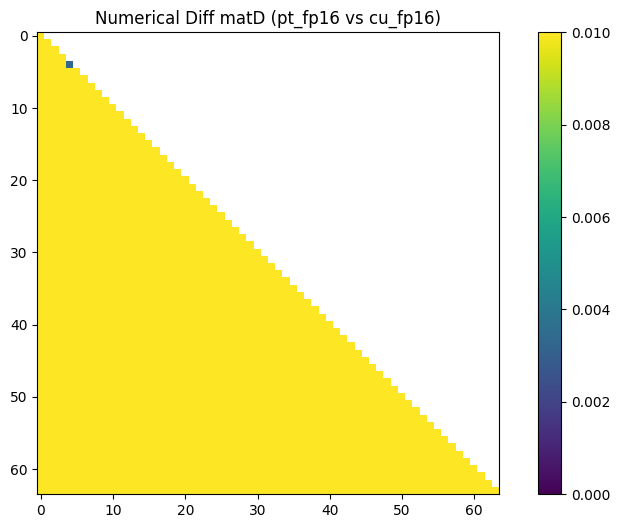

In [23]:
fig = plot_numerical_diffs_single(matLogD_pt, matD_cu_half, title="Numerical Diff matD (pt_fp16 vs cu_fp16)")

In [24]:
# ks_half[:, :, 16:32, 16:]

In [25]:
s_pt_half[:, :, :16, :16]

tensor([[[[  4.7070,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -4.9258,  10.7734,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -5.4180,  -0.2151,   1.3145,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -6.7227,  -1.6094,  -7.0977,  12.0781,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [  1.5518,  -3.0020,  -3.8047,  -3.1270,  -0.1820,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [  8.3906,   5.7578,   1.4111,   3.8711,  21.6719, -21.0938,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

In [26]:
matD_cu_half[:, :, :10, 0:10]

tensor([[[[  4.7070,  12.1797,  -3.3906,  -3.8184,  -4.4102, -16.3750,  -0.7983,  -0.3071,  -9.6094,  -1.3486],
          [ -4.9258,  10.7734, -10.2266,   3.4512,   0.9766,  -1.7695,  12.0234,   7.7188,   1.4180,   3.3223],
          [ -5.4180,  -0.2151,   1.3145,   0.0369,  -6.6172,  -1.0068,  14.7031, -14.9766,  -7.5977, -14.9297],
          [ -6.7227,  -1.6094,  -7.0977,  12.0781,  -5.9922,  15.3750,  -2.7188,  11.3750,   6.1602,  10.4609],
          [  1.5518,  -3.0020,  -3.8047,  -3.1270,  -0.1820,  -6.2500,  -5.4258,  -4.5078,   5.7109, -13.6562],
          [  8.3906,   5.7578,   1.4111,   3.8711,  21.6719, -21.0938,  10.2344,  -8.9453,   2.3438,   2.6660],
          [ -8.4609,  -8.6172,   2.5000,   2.6484,  10.4297,  -3.3047,  11.6719,  -2.1406,  10.6328,   9.8359],
          [ 10.1797,   7.6445,   9.1094,   8.5938,  -2.8086,   4.5039,   6.3516,  -3.7871,   2.0098,   0.4036],
          [  8.0547,  -8.3594,  14.8750,   3.5195,  -9.9219, -14.7578,  -8.5938,   1.4727,  -0.9380, -15

In [27]:
s_pt_half[:, :, :10, :10]

tensor([[[[  4.7070,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -4.9258,  10.7734,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -5.4180,  -0.2151,   1.3145,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -6.7227,  -1.6094,  -7.0977,  12.0781,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [  1.5518,  -3.0020,  -3.8047,  -3.1270,  -0.1820,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [  8.3906,   5.7578,   1.4111,   3.8711,  21.6719, -21.0938,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -8.4609,  -8.6172,   2.5000,   2.6484,  10.4297,  -3.3047,  11.6719,   0.0000,   0.0000,   0.0000],
          [ 10.1797,   7.6445,   9.1094,   8.5938,  -2.8086,   4.5039,   6.3516,  -3.7871,   0.0000,   0.0000],
          [  8.0547,  -8.3594,  14.8750,   3.5195,  -9.9219, -14.7578,  -8.5938,   1.4727,  -0.9380,   0

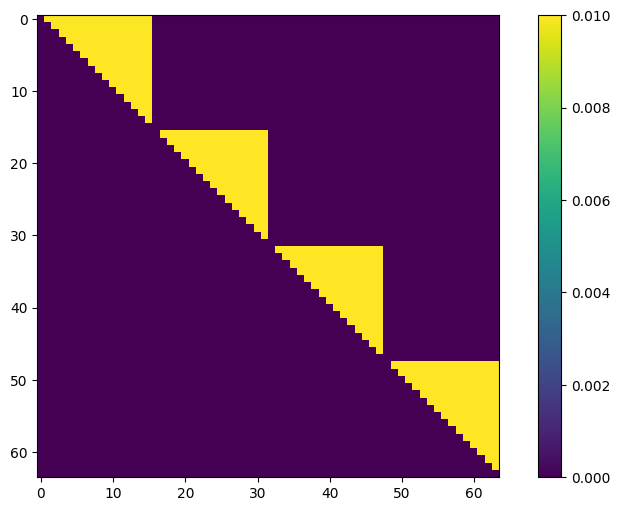

In [28]:
fig = plot_numerical_diffs_single(s_pt_half, matD_cu_half)

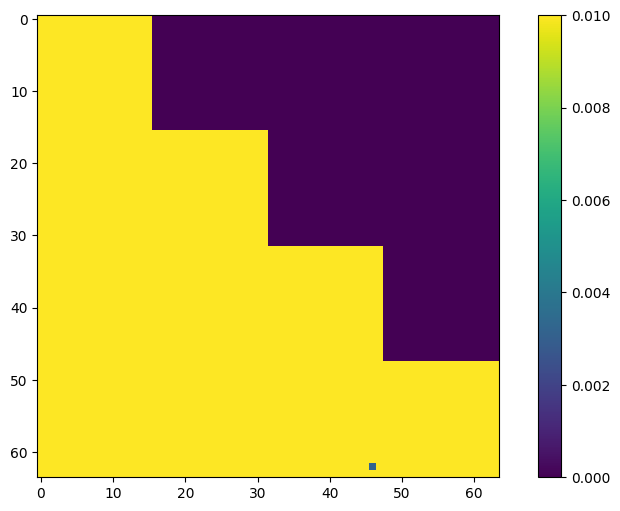

In [29]:
fig = plot_numerical_diffs_single(matD_cu_half)

In [30]:
s_pt_half[:, :, :10, :10]

tensor([[[[  4.7070,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -4.9258,  10.7734,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -5.4180,  -0.2151,   1.3145,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -6.7227,  -1.6094,  -7.0977,  12.0781,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [  1.5518,  -3.0020,  -3.8047,  -3.1270,  -0.1820,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [  8.3906,   5.7578,   1.4111,   3.8711,  21.6719, -21.0938,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -8.4609,  -8.6172,   2.5000,   2.6484,  10.4297,  -3.3047,  11.6719,   0.0000,   0.0000,   0.0000],
          [ 10.1797,   7.6445,   9.1094,   8.5938,  -2.8086,   4.5039,   6.3516,  -3.7871,   0.0000,   0.0000],
          [  8.0547,  -8.3594,  14.8750,   3.5195,  -9.9219, -14.7578,  -8.5938,   1.4727,  -0.9380,   0

In [31]:
(s_pt_half - matD_cu_half)[:, : , :10, :10]

tensor([[[[  0.0000, -12.1797,   3.3906,   3.8184,   4.4102,  16.3750,   0.7983,   0.3071,   9.6094,   1.3486],
          [  0.0000,   0.0000,  10.2266,  -3.4512,  -0.9766,   1.7695, -12.0234,  -7.7188,  -1.4180,  -3.3223],
          [  0.0000,   0.0000,   0.0000,  -0.0369,   6.6172,   1.0068, -14.7031,  14.9766,   7.5977,  14.9297],
          [  0.0000,   0.0000,   0.0000,   0.0000,   5.9922, -15.3750,   2.7188, -11.3750,  -6.1602, -10.4609],
          [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   6.2500,   5.4258,   4.5078,  -5.7109,  13.6562],
          [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000, -10.2344,   8.9453,  -2.3438,  -2.6660],
          [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   2.1406, -10.6328,  -9.8359],
          [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  -2.0098,  -0.4036],
          [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  15

In [32]:
(s_pt_half - matD_cu_half).abs().max()

tensor(28.1406, device='cuda:0', dtype=torch.float16)

In [33]:
vs_half[:, :, :3, 32:]

tensor([[[[ 8.4326e-01,  2.5024e-01,  1.9668e+00, -7.2607e-01, -1.2266e+00,  1.9922e-01, -1.4668e+00, -6.7188e-01, -1.1328e+00,  1.1963e+00, -2.1912e-02, -2.8015e-02, -1.1530e-01,  1.5240e-03,
            7.8857e-01,  2.9565e-01,  1.1113e+00,  9.4580e-01, -7.9980e-01,  7.6221e-01,  1.0244e+00, -1.7090e+00, -3.4009e-01, -3.1274e-01,  1.3672e+00, -7.6123e-01, -1.8396e-01, -7.4707e-01,
            6.4697e-02,  1.2637e+00,  4.2139e-01,  2.8687e-01],
          [ 9.9243e-02, -1.4707e+00, -1.2178e+00, -4.6240e-01,  4.9146e-01,  8.5400e-01,  9.8291e-01,  1.9541e+00,  8.6035e-01, -2.2937e-01, -1.5371e+00, -1.4473e+00, -3.9478e-01,  4.9243e-01,
            1.3184e-01, -6.9092e-01,  1.5735e-01, -1.4453e+00,  1.1357e+00,  4.7827e-01, -4.3066e-01, -1.0195e+00,  1.5186e+00, -5.8154e-01, -1.3721e+00, -8.8379e-02, -1.4287e+00, -1.2383e+00,
           -1.2344e+00,  1.9795e+00,  9.5996e-01,  1.1768e+00],
          [ 2.4548e-01,  2.4866e-01,  1.0977e+00,  1.3359e+00,  4.2755e-02, -1.7949e+00, -8.0420e-01

In [34]:
matD_cu_half.shape

torch.Size([1, 1, 64, 64])

In [35]:
matD_cu_half[:, :, :10, :10]

tensor([[[[  4.7070,  12.1797,  -3.3906,  -3.8184,  -4.4102, -16.3750,  -0.7983,  -0.3071,  -9.6094,  -1.3486],
          [ -4.9258,  10.7734, -10.2266,   3.4512,   0.9766,  -1.7695,  12.0234,   7.7188,   1.4180,   3.3223],
          [ -5.4180,  -0.2151,   1.3145,   0.0369,  -6.6172,  -1.0068,  14.7031, -14.9766,  -7.5977, -14.9297],
          [ -6.7227,  -1.6094,  -7.0977,  12.0781,  -5.9922,  15.3750,  -2.7188,  11.3750,   6.1602,  10.4609],
          [  1.5518,  -3.0020,  -3.8047,  -3.1270,  -0.1820,  -6.2500,  -5.4258,  -4.5078,   5.7109, -13.6562],
          [  8.3906,   5.7578,   1.4111,   3.8711,  21.6719, -21.0938,  10.2344,  -8.9453,   2.3438,   2.6660],
          [ -8.4609,  -8.6172,   2.5000,   2.6484,  10.4297,  -3.3047,  11.6719,  -2.1406,  10.6328,   9.8359],
          [ 10.1797,   7.6445,   9.1094,   8.5938,  -2.8086,   4.5039,   6.3516,  -3.7871,   2.0098,   0.4036],
          [  8.0547,  -8.3594,  14.8750,   3.5195,  -9.9219, -14.7578,  -8.5938,   1.4727,  -0.9380, -15

In [36]:
hs_cu_half[:, :, :3, 32:]

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]], device='cuda:0', dtype=torch.float16)

In [37]:
(vs_half-hs_cu_half)[:, :, :3, 32:]

tensor([[[[ 8.4326e-01,  2.5024e-01,  1.9668e+00, -7.2607e-01, -1.2266e+00,  1.9922e-01, -1.4668e+00, -6.7188e-01, -1.1328e+00,  1.1963e+00, -2.1912e-02, -2.8015e-02, -1.1530e-01,  1.5240e-03,
            7.8857e-01,  2.9565e-01,  1.1113e+00,  9.4580e-01, -7.9980e-01,  7.6221e-01,  1.0244e+00, -1.7090e+00, -3.4009e-01, -3.1274e-01,  1.3672e+00, -7.6123e-01, -1.8396e-01, -7.4707e-01,
            6.4697e-02,  1.2637e+00,  4.2139e-01,  2.8687e-01],
          [ 9.9243e-02, -1.4707e+00, -1.2178e+00, -4.6240e-01,  4.9146e-01,  8.5400e-01,  9.8291e-01,  1.9541e+00,  8.6035e-01, -2.2937e-01, -1.5371e+00, -1.4473e+00, -3.9478e-01,  4.9243e-01,
            1.3184e-01, -6.9092e-01,  1.5735e-01, -1.4453e+00,  1.1357e+00,  4.7827e-01, -4.3066e-01, -1.0195e+00,  1.5186e+00, -5.8154e-01, -1.3721e+00, -8.8379e-02, -1.4287e+00, -1.2383e+00,
           -1.2344e+00,  1.9795e+00,  9.5996e-01,  1.1768e+00],
          [ 2.4548e-01,  2.4866e-01,  1.0977e+00,  1.3359e+00,  4.2755e-02, -1.7949e+00, -8.0420e-01

In [38]:
# cuda kernel bfloat16
hs_cu_bf16, n_cu_bf16, m_cu_bf16, matD_cu_bf16 = vlstm_fw_cuda(mat_Q=qs_bf16, mat_K=ks_bf16, mat_V=vs_bf16, vec_igp=igs_bf16, vec_fgp=fgs_bf16)

before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 64, DH: 64
NUM_WARPS:4, GMEM_LOAD_BLOCK_COLS_X:4, GMEM_LOAD_BLOCK_ROWS_Y:32
blocksxy: 1-1, threadsxy: 128-1, QtileDim: 64, KVtileDim: 64, shared_mem in bytes: 67840
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 128, bdim.y: 1
In FW-Kernel: QtileDim: 64, KVtileDim: 64


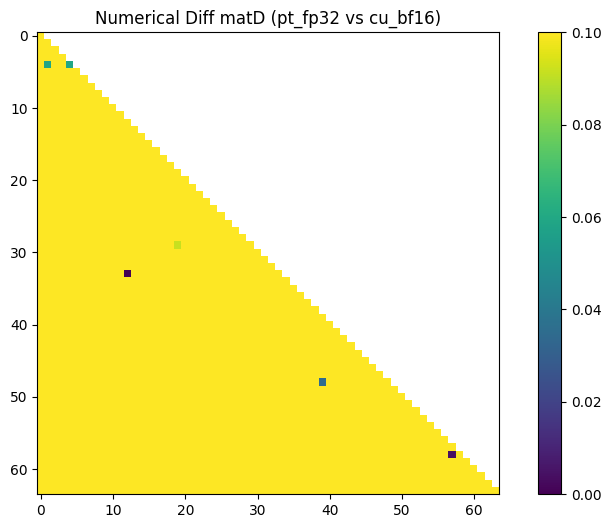

In [39]:
fig = plot_numerical_diffs_single(matLogD_pt, matD_cu_bf16, title="Numerical Diff matD (pt_fp32 vs cu_bf16)", vmax=10e-2)

In [40]:
matD_cu_bf16[:, :, :17, :16]

tensor([[[[ 4.6562e+00,  1.2125e+01, -3.3750e+00, -3.8281e+00, -4.4375e+00, -1.6375e+01, -7.8125e-01, -2.8906e-01, -9.5625e+00, -1.3672e+00, -2.8906e+00, -8.5625e+00, -6.7188e+00, -4.4375e+00,
           -6.1562e+00, -1.0500e+01],
          [-4.9375e+00,  1.0750e+01, -1.0250e+01,  3.4531e+00,  9.8828e-01, -1.7656e+00,  1.2062e+01,  7.7188e+00,  1.4375e+00,  3.3594e+00, -2.9219e+00,  3.6719e+00, -1.0062e+01, -1.0938e+00,
           -1.6484e+00,  2.7344e+00],
          [-5.4375e+00, -2.1680e-01,  1.3125e+00,  4.3457e-02, -6.6562e+00, -1.0234e+00,  1.4688e+01, -1.4938e+01, -7.5938e+00, -1.4938e+01,  2.5156e+00, -3.0156e+00, -6.2891e-01,  5.9375e+00,
            5.9688e+00, -2.0000e+00],
          [-6.7500e+00, -1.6094e+00, -7.0938e+00,  1.2062e+01, -5.9688e+00,  1.5375e+01, -2.7344e+00,  1.1375e+01,  6.1250e+00,  1.0500e+01, -1.3000e+01,  7.0938e+00, -3.3750e+00,  4.0625e+00,
            4.6562e+00,  3.0273e-01],
          [ 1.5391e+00, -3.0000e+00, -3.8281e+00, -3.1406e+00, -1.2598e-01, 

In [41]:
(qs_bf16 @ ks_bf16)[:, :, :17, :16]

tensor([[[[-2.3281e+00,  4.2188e+00, -6.8125e+00, -1.0688e+01, -9.9375e+00,  1.0250e+01, -2.8438e+00,  1.9609e+00,  9.3750e-01, -4.5312e+00, -9.6250e+00, -1.3672e-01,  1.5078e+00,  3.1406e+00,
            1.8750e+00, -2.2031e+00],
          [-5.7500e+00, -3.9531e+00, -8.8125e+00, -3.2227e-01,  1.2250e+01, -7.6250e+00,  8.5000e+00,  5.5625e+00, -7.9688e+00, -8.6670e-03, -6.1562e+00,  8.6250e+00, -1.4062e+01, -7.2500e+00,
            4.0625e+00,  8.1875e+00],
          [-2.6562e+00,  5.1250e+00,  6.7812e+00, -8.0625e+00, -1.0125e+01,  1.0312e+00, -4.2188e+00, -1.1172e+00,  6.9062e+00, -1.0078e+00, -2.5391e-02,  7.3125e+00,  6.4844e-01, -7.1250e+00,
            1.7500e+00,  9.8125e+00],
          [ 5.3125e+00, -2.4375e+00, -5.6875e+00,  1.4000e+01, -1.7266e+00,  3.0156e+00, -1.0062e+01, -5.1875e+00, -6.9375e+00,  2.3281e+00,  8.5000e+00,  4.0938e+00, -9.8750e+00, -7.9102e-02,
           -4.2188e+00, -2.5781e+00],
          [ 5.9375e+00,  4.2188e+00, -3.2656e+00,  6.4375e+00,  6.7812e+00, 

In [42]:
hs_cu_half.shape, qs_half.shape

(torch.Size([1, 1, 64, 64]), torch.Size([1, 1, 64, 64]))

In [43]:
hs_cu_half, qs

(tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [44]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matLogD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matLogD_pt).tril())}")

print(f"====== Half ======")
print(f"fw hs match: {torch.allclose(hs_cu_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_half.float() - matLogD_pt).tril(), torch.zeros_like((matLogD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_half - matLogD_pt).tril())}")

print(f"====== bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_cu_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_bf16.float() - matLogD_pt).tril(), torch.zeros_like((matLogD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_bf16 - matLogD_pt).tril())}")


Match against pt float32:
====== Full ======
fw hs match: True, max diff: 0.0
fw n match: True, max diff: 0.0
fw m match: True, max diff: 0.0
fw D match: False, max diff: 55.879150390625
====== Half ======
fw hs match: False, max diff: 4.586074352264404
fw n match: False, max diff: 3.7951691150665283
fw m match: False, max diff: 2.3591573238372803
fw D match: False, max diff: 71.31419372558594
====== bfloat16 ======
fw hs match: False, max diff: 4.586074352264404
fw n match: False, max diff: 3.7951691150665283
fw m match: False, max diff: 2.3591573238372803
fw D match: False, max diff: 71.37669372558594


In [45]:
16 / 4

4.0

In [46]:
13 % 4, 14 % 4

(1, 2)

In [47]:
# ====== Full -> bfloat16 ======
# fw hs match: False, max diff: 0.15340876579284668
# fw n match: False, max diff: 0.09692215919494629
# fw m match: False, max diff: 0.05207604169845581
# fw D match: False, max diff: 0.15224838256835938
# ---------------------------------
# bw dQs match: False, max diff: 0.13966524600982666
# bw dKs match: False, max diff: 0.13031554222106934
# bw dVs match: False, max diff: 0.09818196296691895
# bw dIgs match: False, max diff: 0.12595558166503906
# bw dFgs match: False, max diff: 0.08353292942047119

### visualize diffs

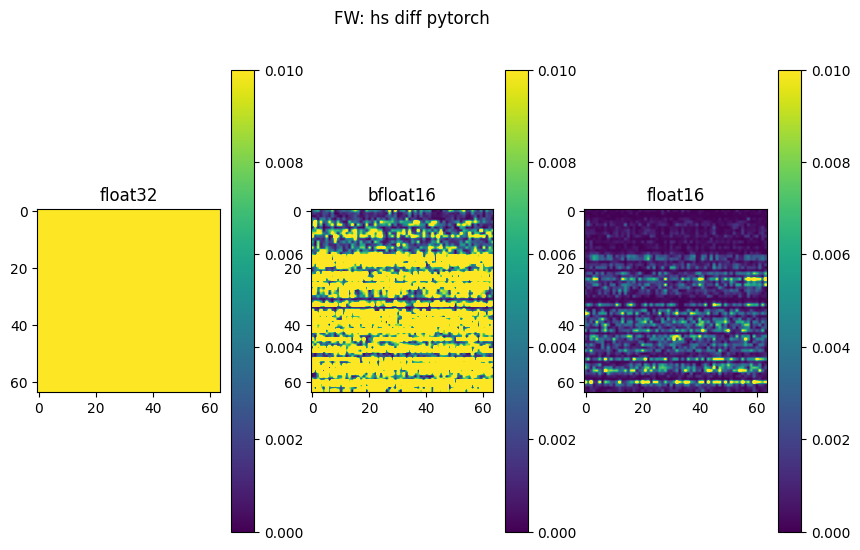

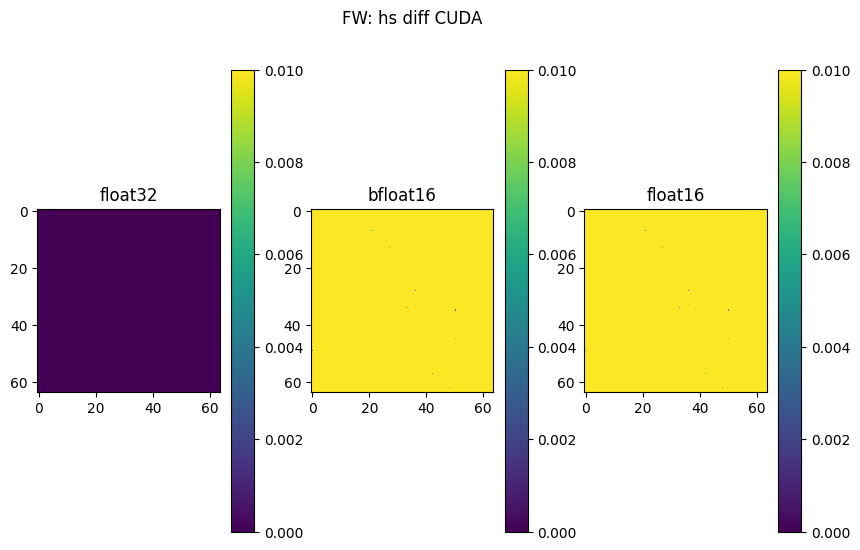

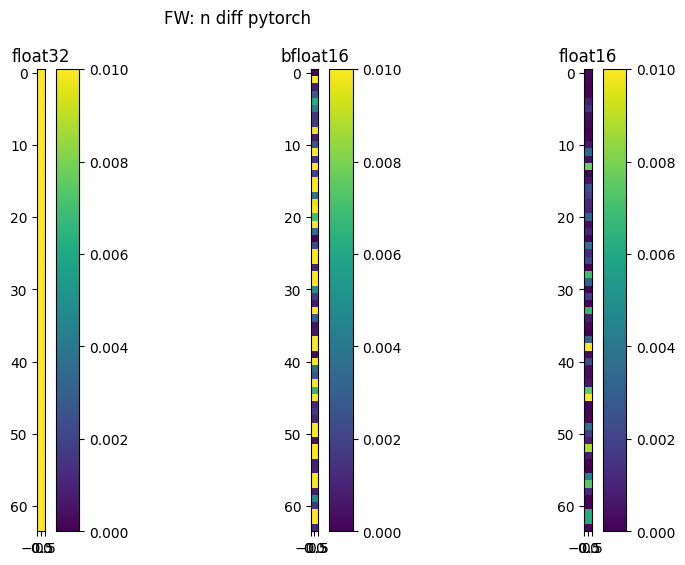

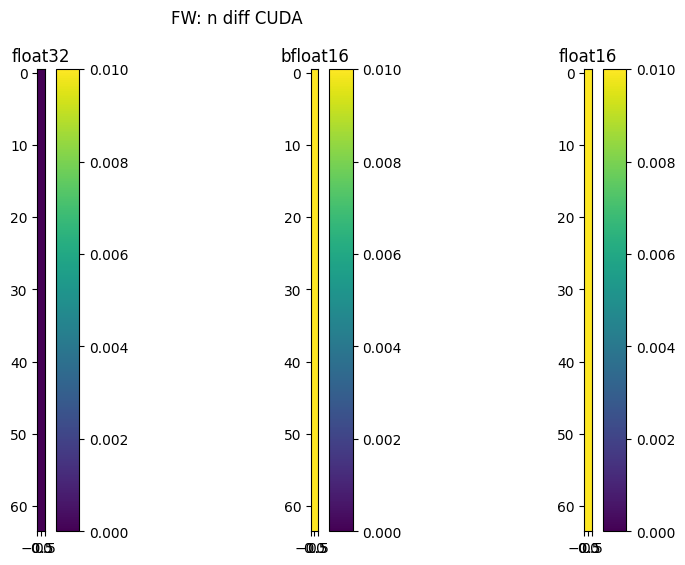

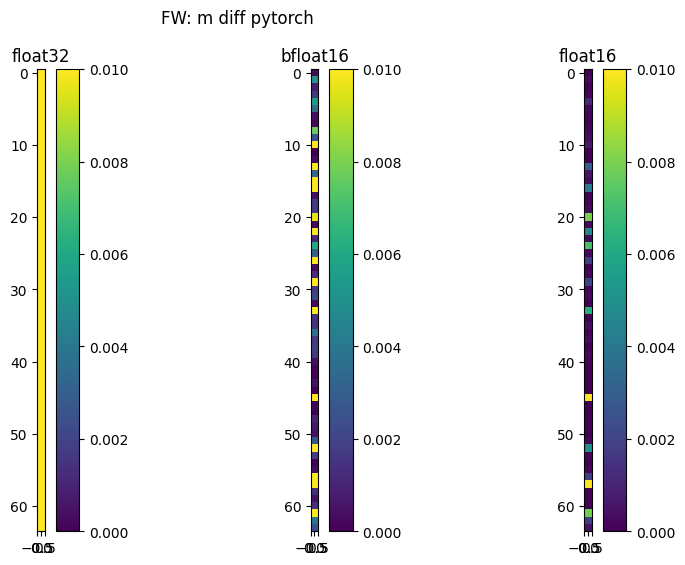

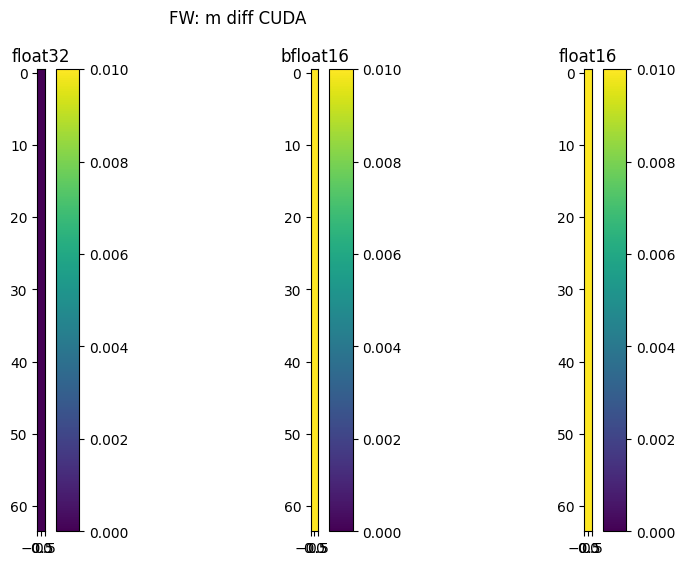

In [48]:
## fw diffs
# hs
fig = plot_numerical_diffs(hs_pt, 10*torch.ones_like(hs_pt), hs_pt_bf16, hs_pt_half, title="FW: hs diff pytorch")
fig = plot_numerical_diffs(hs_pt, hs_cu, hs_cu_bf16, hs_cu_half, title="FW: hs diff CUDA")
# n 
fig = plot_numerical_diffs(n_pt, 10*torch.ones_like(n_pt), n_pt_bf16, n_pt_half, title="FW: n diff pytorch")
fig = plot_numerical_diffs(n_pt, n_cu, n_cu_bf16, n_cu_half, title="FW: n diff CUDA")
# m
fig = plot_numerical_diffs(m_pt, 10*torch.ones_like(m_pt), m_pt_bf16, m_pt_half, title="FW: m diff pytorch")
fig = plot_numerical_diffs(m_pt, m_cu, m_cu_bf16, m_cu_half, title="FW: m diff CUDA")